# Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Init

In [1]:
import math

import numpy as np
import pandas as pd
import re
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

import torch
import transformers

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## Conclusion:
**Our data doesn't have missing value in any column and having appropriate data type.**

**Since our task is to classify reviews only we will only consider review and pos columns for Training our model.**

# EDA

Let's check the number of movies and reviews over years.

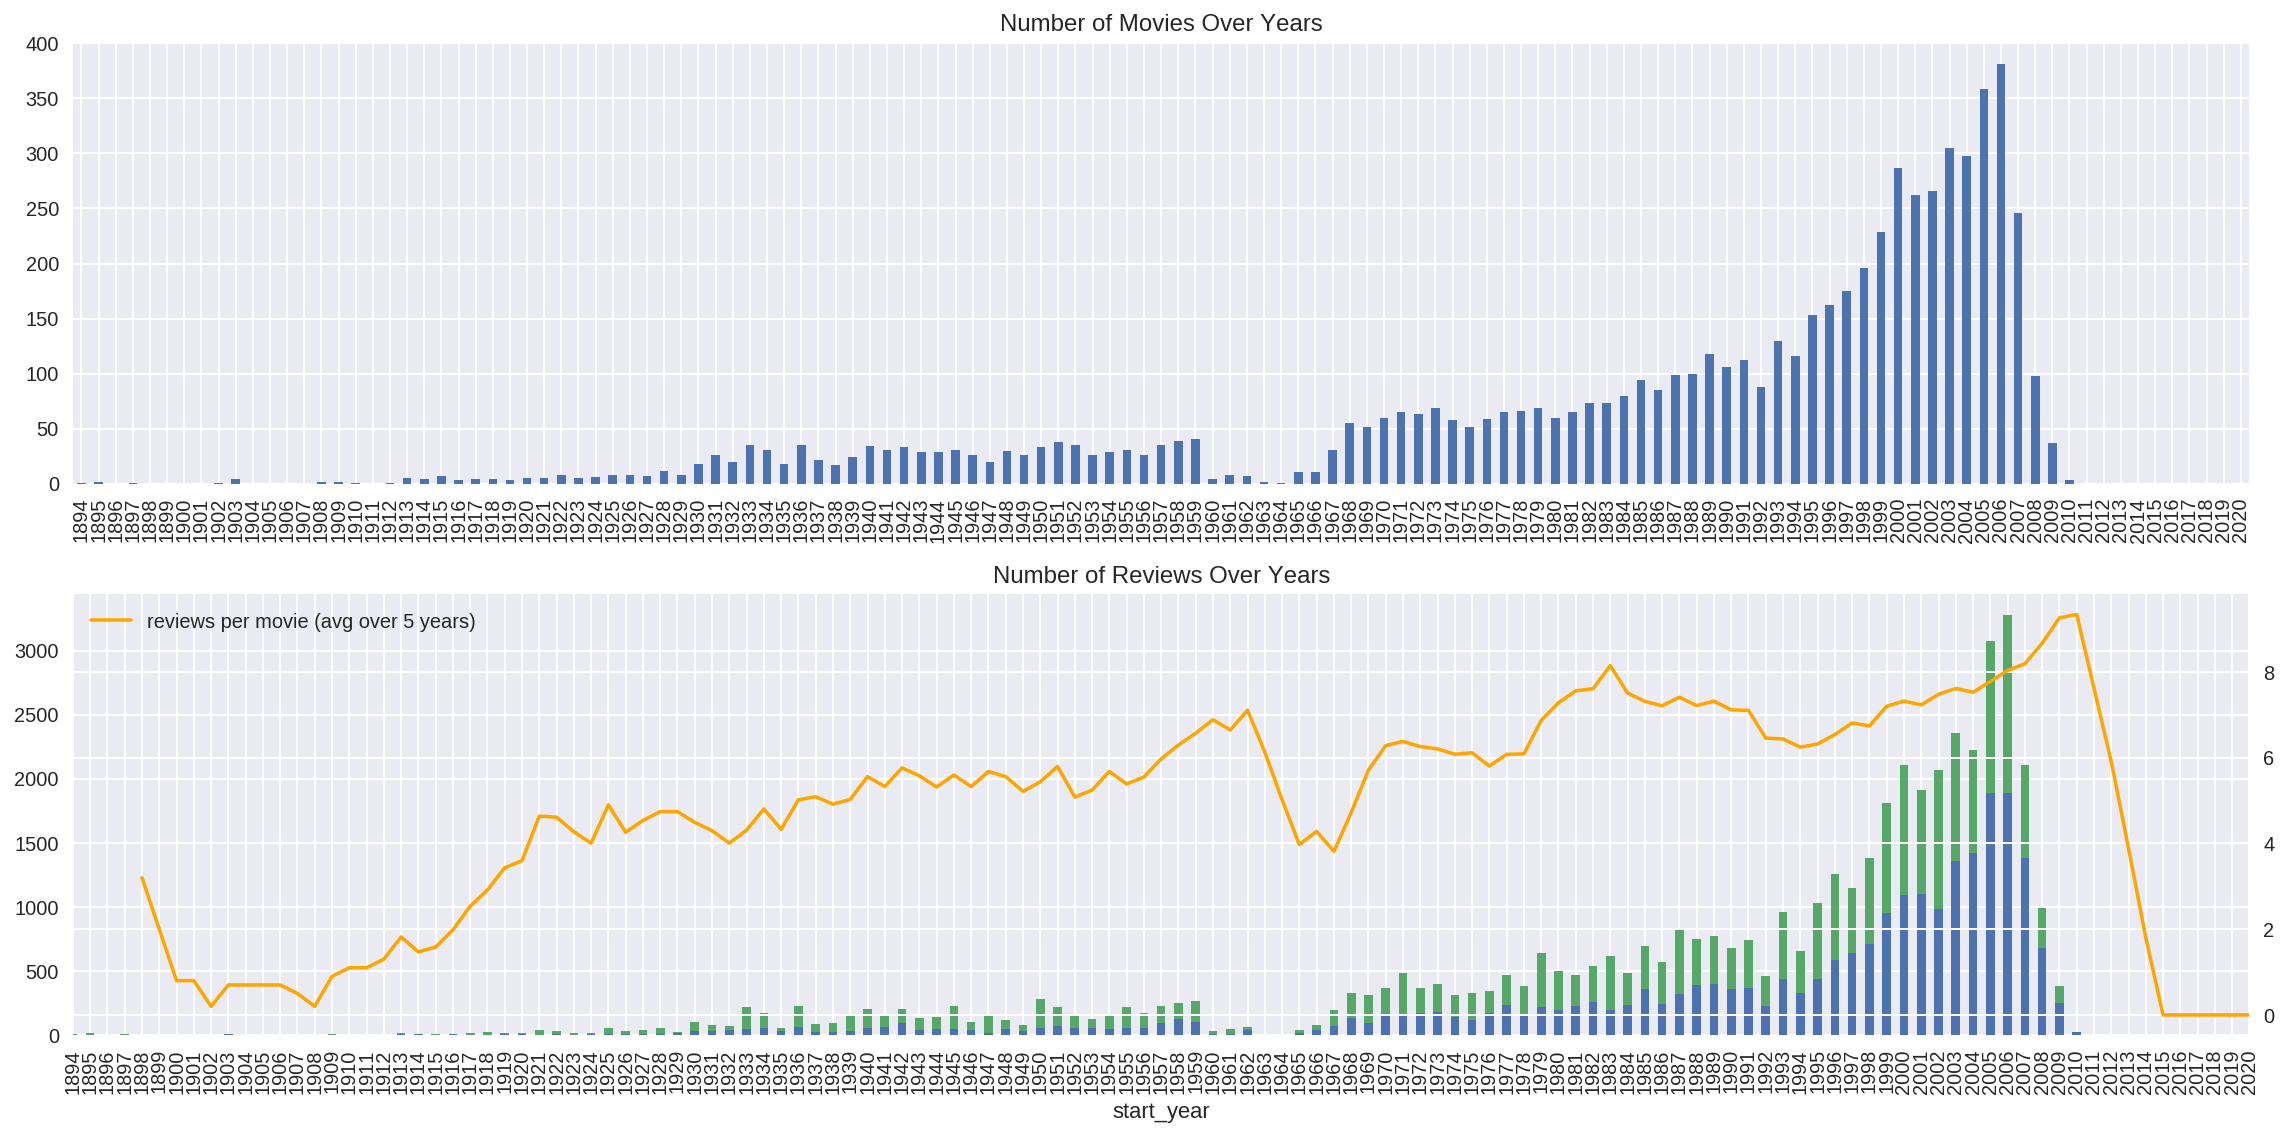

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that number of movie reviews are increasing over the years till 2006 excepts the year range 1960-1996. After 2006 it decreases.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

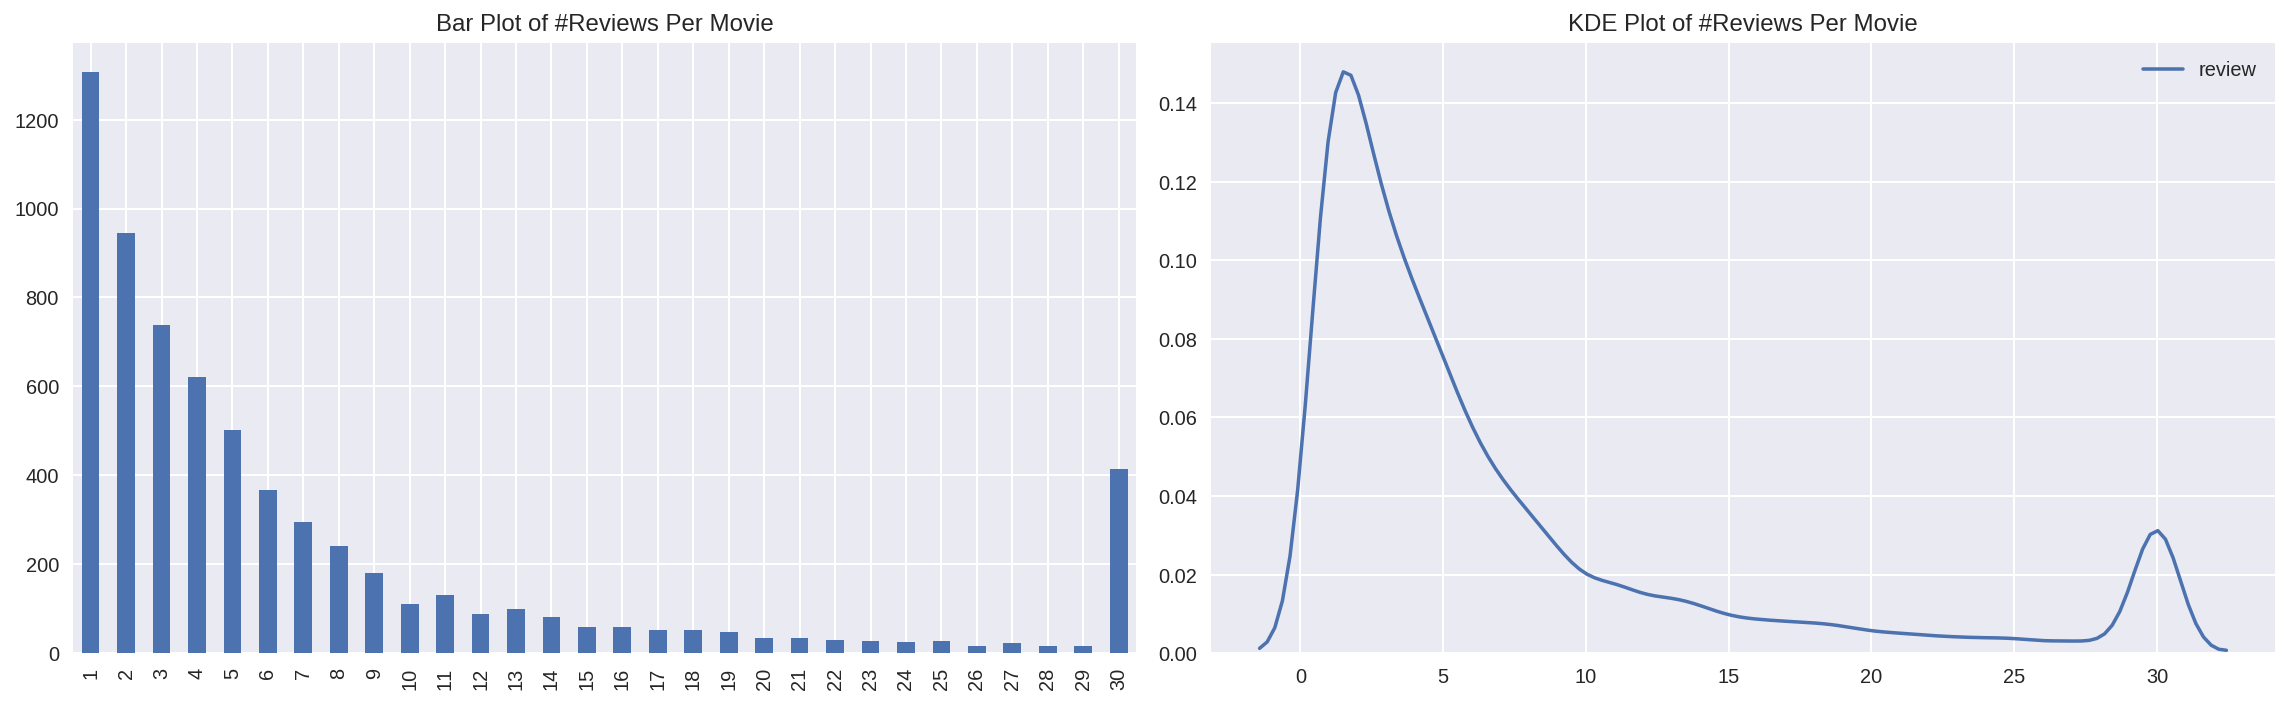

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We can say that most of the movies are distributed in (0-9) movies range and few significant movie reviews for movie 30

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

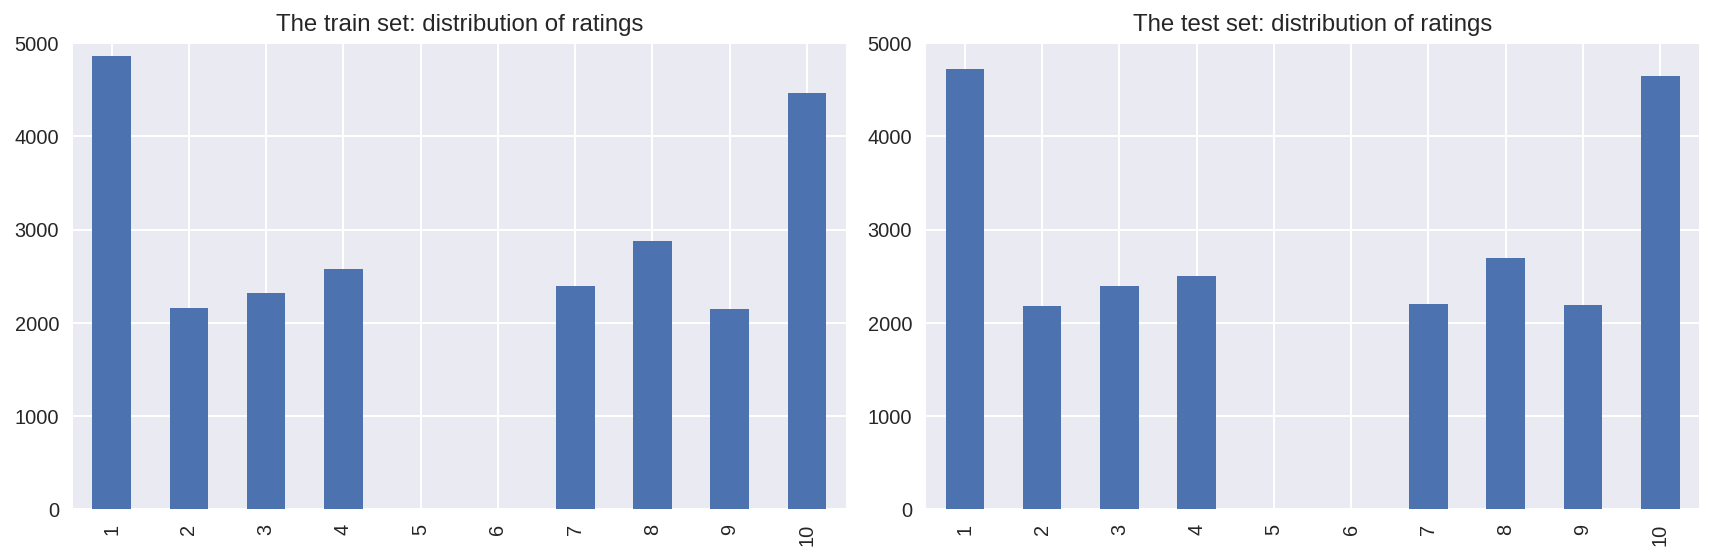

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

This shows that train and test set review distribution are almost same

Distribution of negative and positive reviews over the years for two parts of the dataset

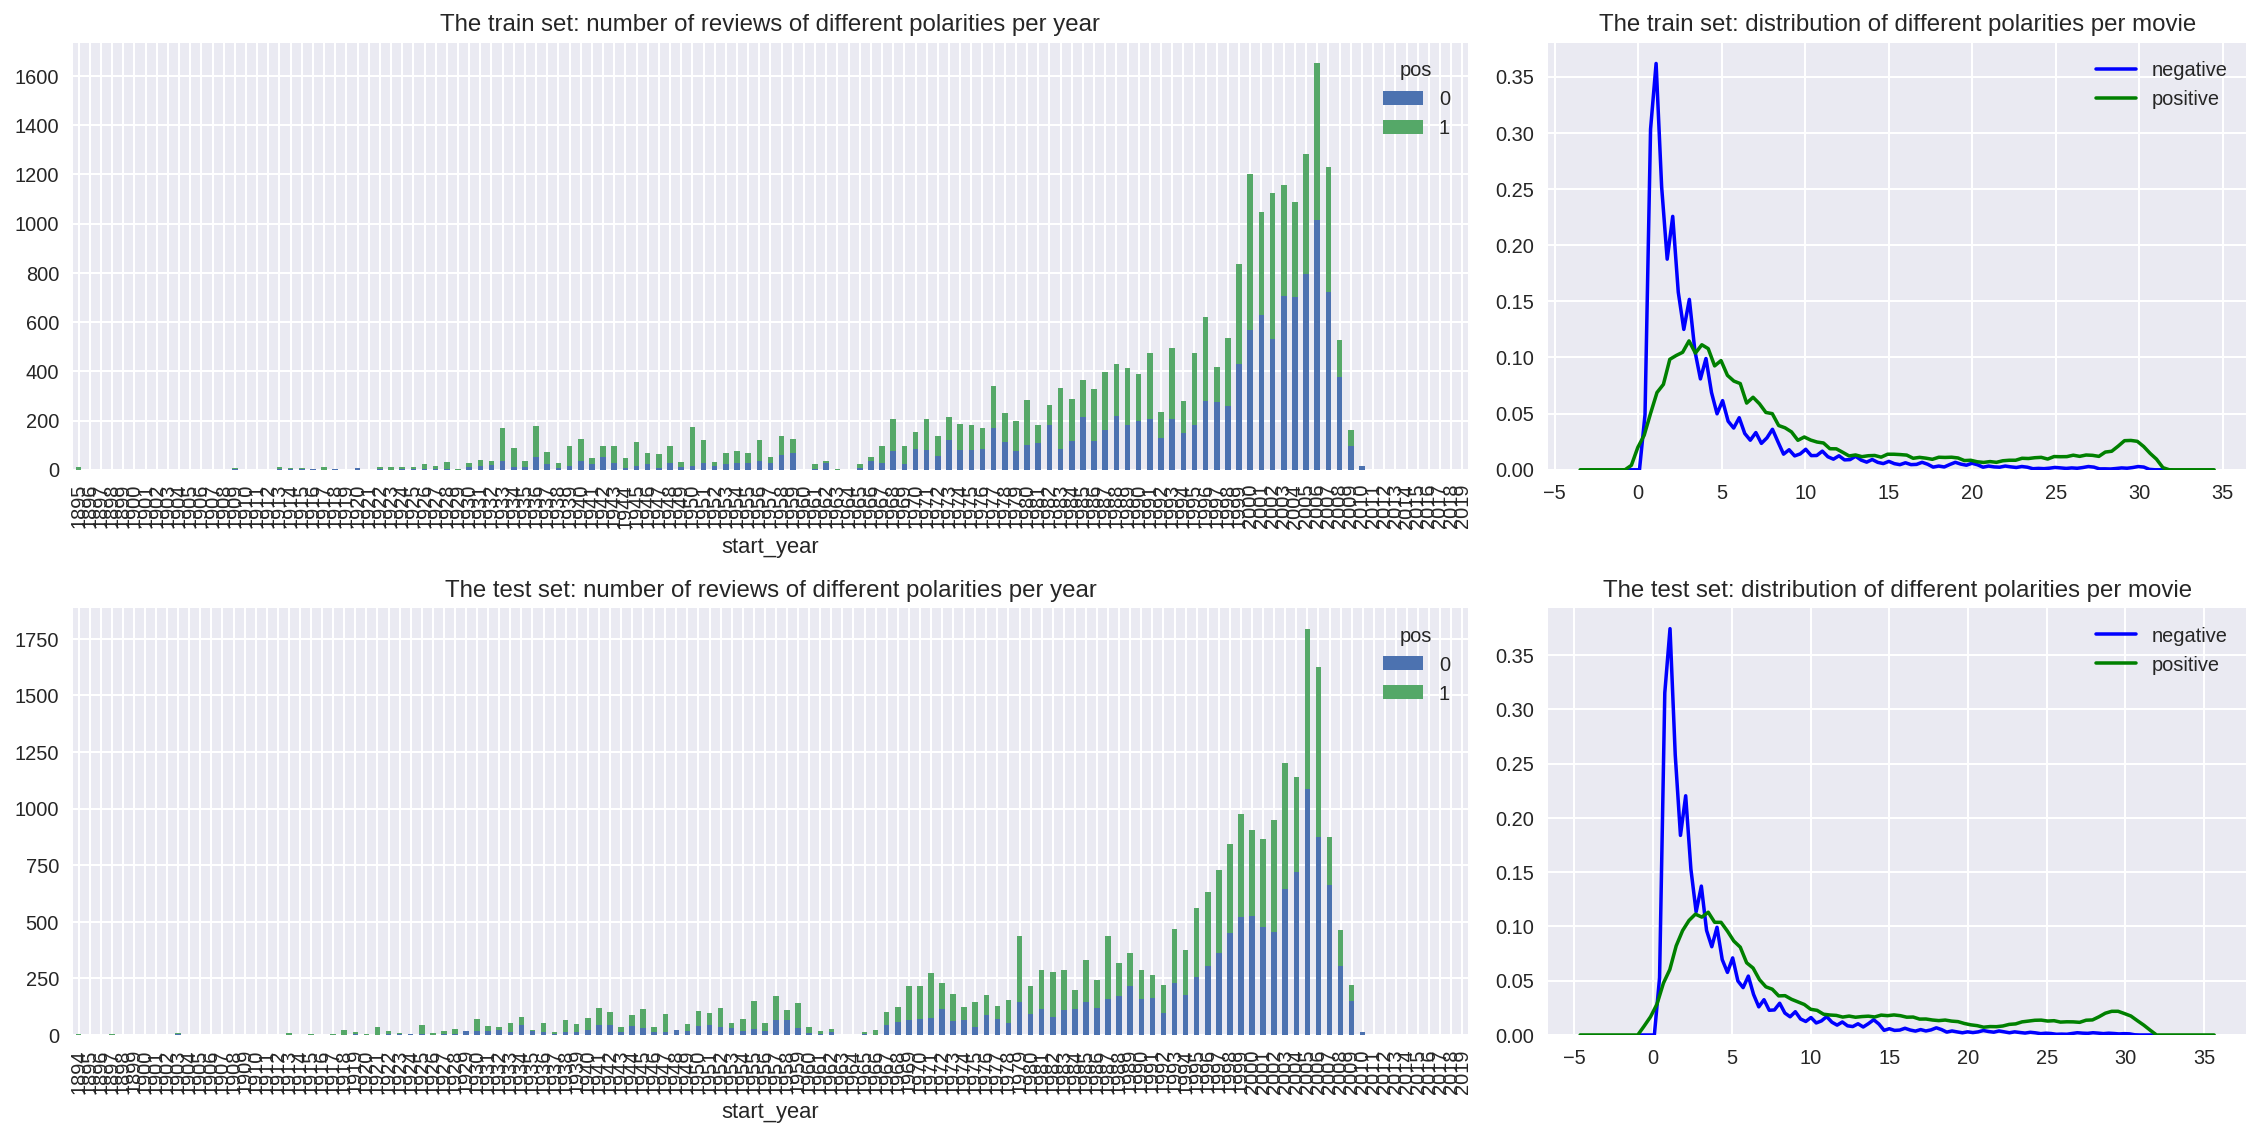

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset are also almost same so we can that our test set is perfect to use

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
def normalize(text):
    text=re.sub(r"[^a-zA-Z']", " ", text)
    text=" ".join(text.split())
    return text.lower()

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

In [18]:
df_reviews['review'][0]

"The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!"

In [19]:
df_reviews['review_norm'][0]

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there's always an irritating sound in the background whether it's a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie"

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [21]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

# Model 0 - Constant

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
count_vect = CountVectorizer()
bow = count_vect.fit(train_features)
train_features_0 = bow.transform(train_features)
test_features_0 = bow.transform(test_features)

In [24]:
dummy_clf = DummyClassifier()

In [25]:
dummy_clf.fit(train_features_0, train_target)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

          train  test
Accuracy   0.49  0.50
F1         0.49  0.50
APS        0.50  0.50
ROC AUC    0.50  0.49


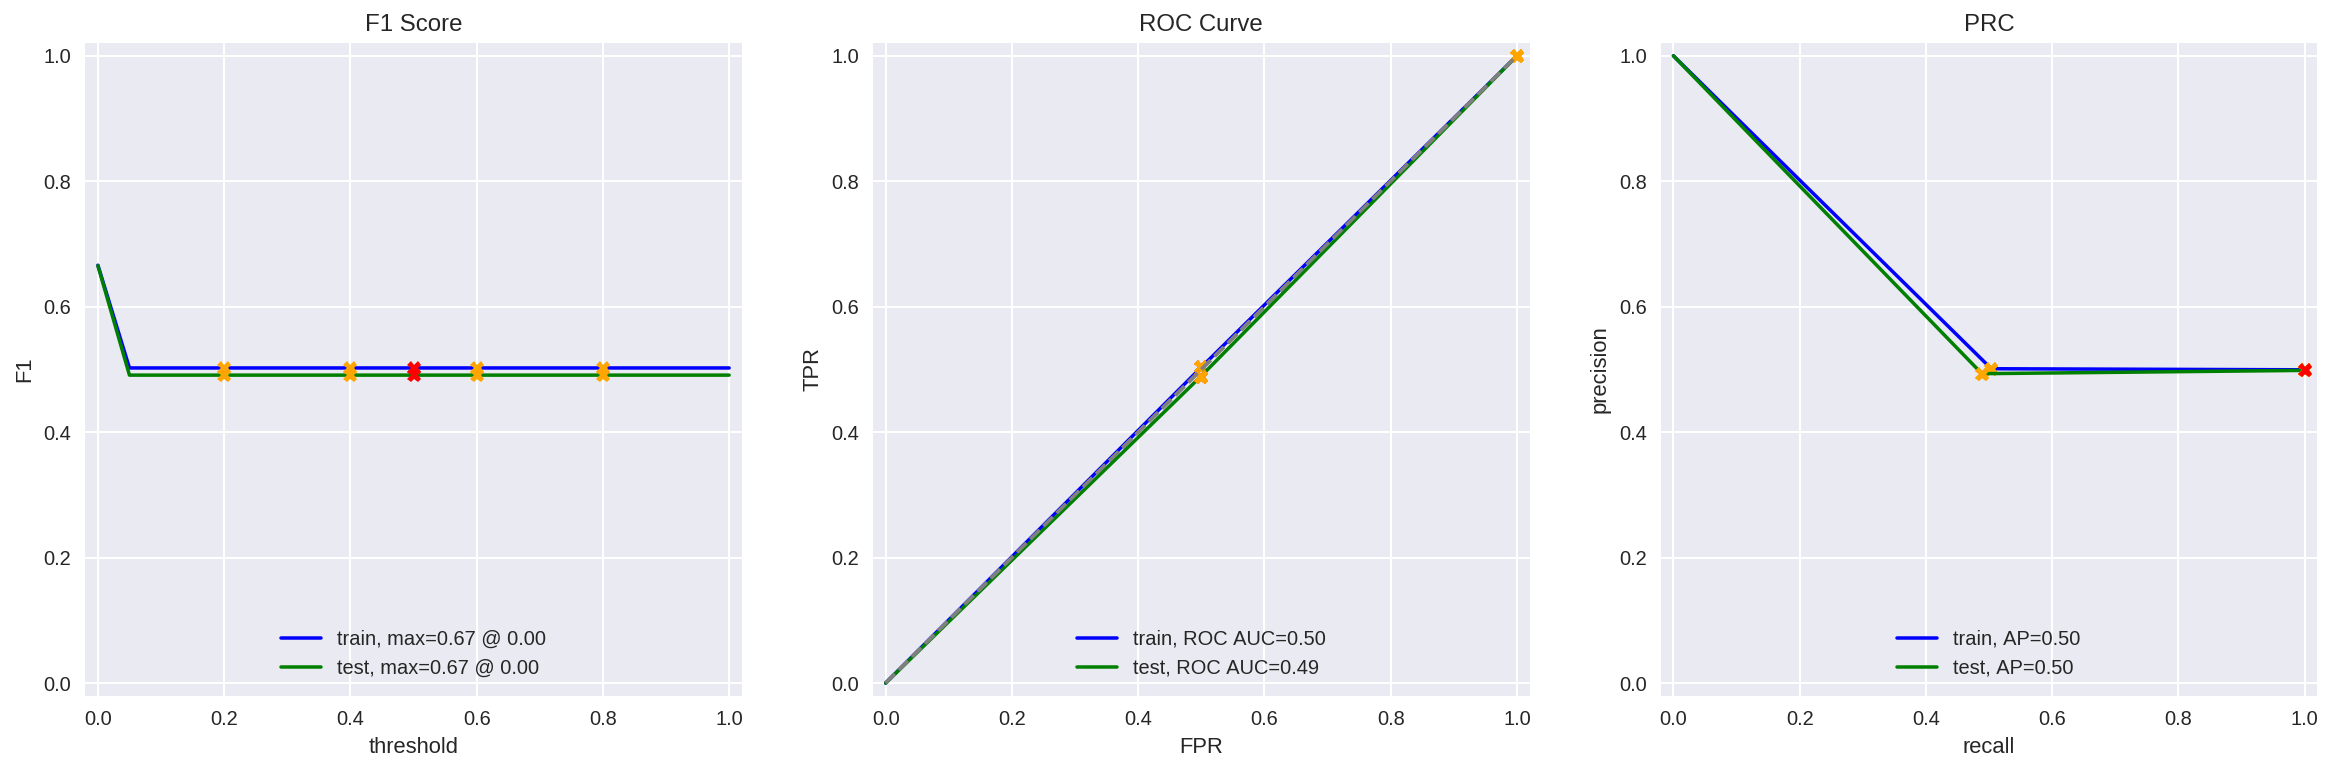

In [26]:
evaluate_model(dummy_clf, train_features_0, train_target, test_features_0, test_target)

# Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [27]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [28]:
stop_words = set(stopwords.words('english'))

In [29]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer_1.fit(train_features)

In [30]:
train_features_1 = tfidf.transform(train_features)
test_features_1 = tfidf.transform(test_features)

In [31]:
logistic_clf_1 = LogisticRegression()
logistic_clf_1.fit(train_features_1, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


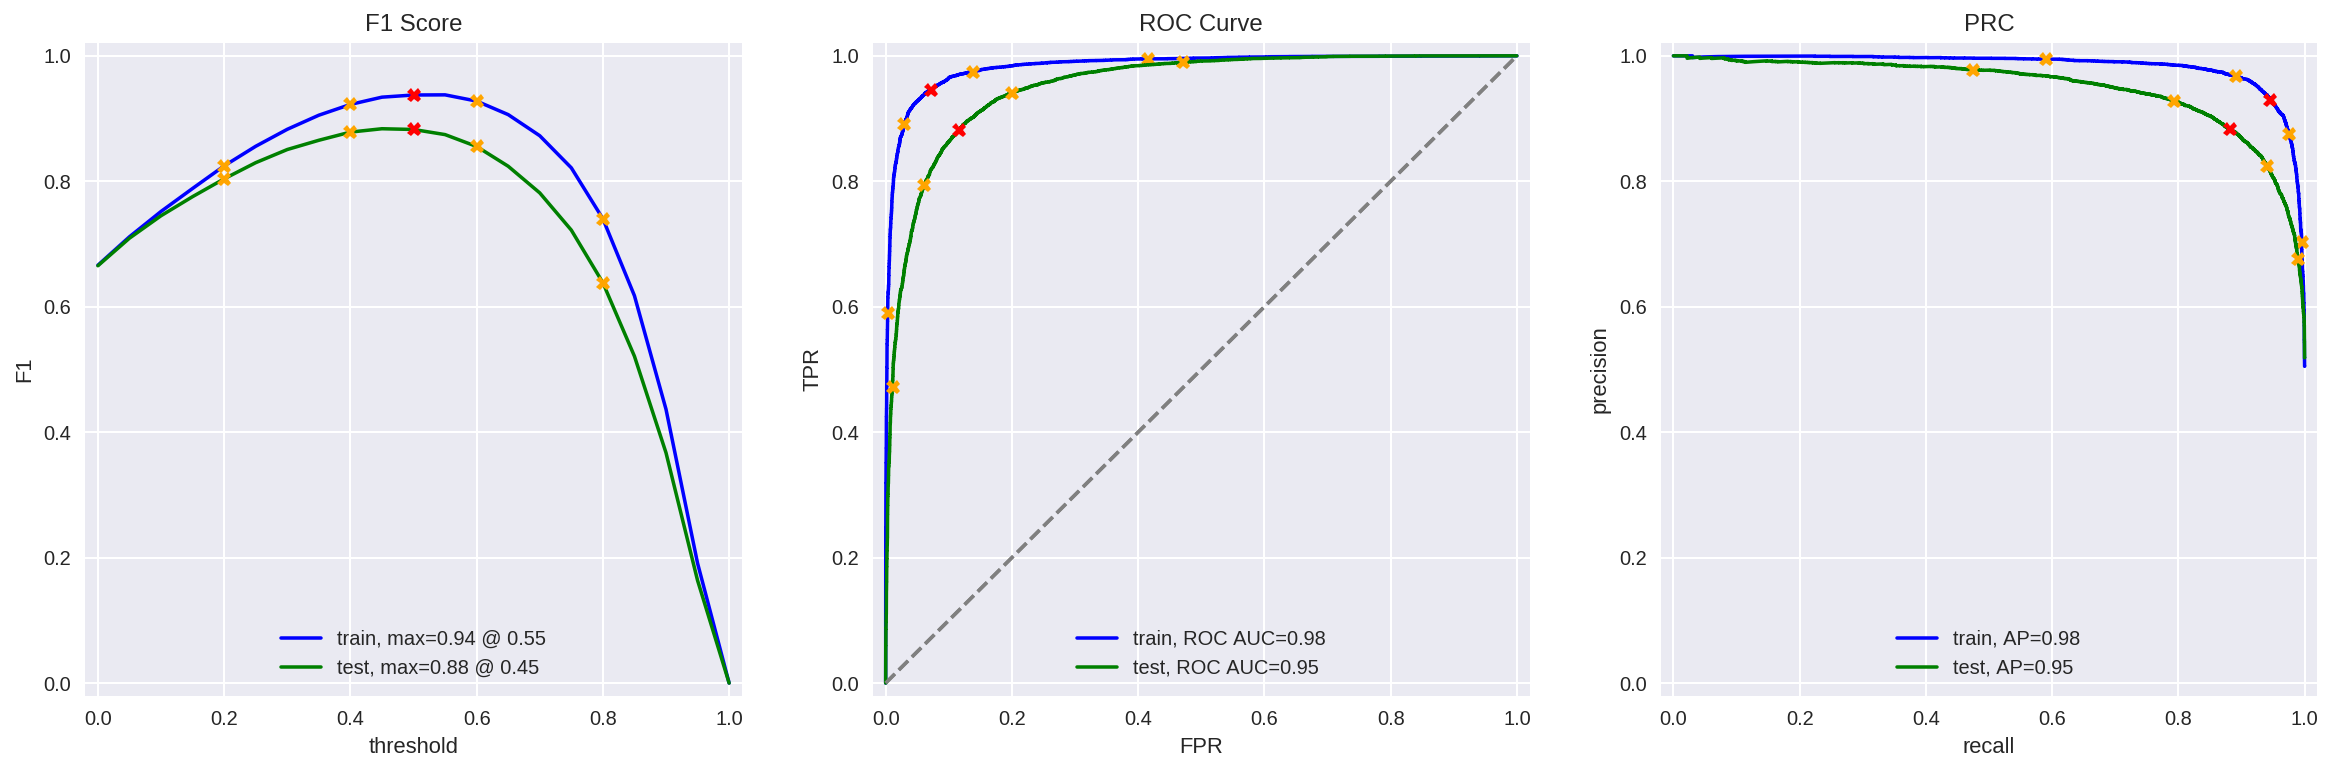

In [44]:
evaluate_model(logistic_clf_1, train_features_1, train_target, test_features_1, test_target)

# Model 3 - spaCy, TF-IDF and LR

In [33]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [35]:
train_features_lemma = train_features.apply(text_preprocessing_3)
test_features_lemma = test_features.apply(text_preprocessing_3)

In [36]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer_2.fit(train_features_lemma)

In [37]:
train_features_2 = tfidf.transform(train_features_lemma)
test_features_2 = tfidf.transform(test_features_lemma)

In [39]:
logistic_clf_2 = LogisticRegression()
logistic_clf_2.fit(train_features_2, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


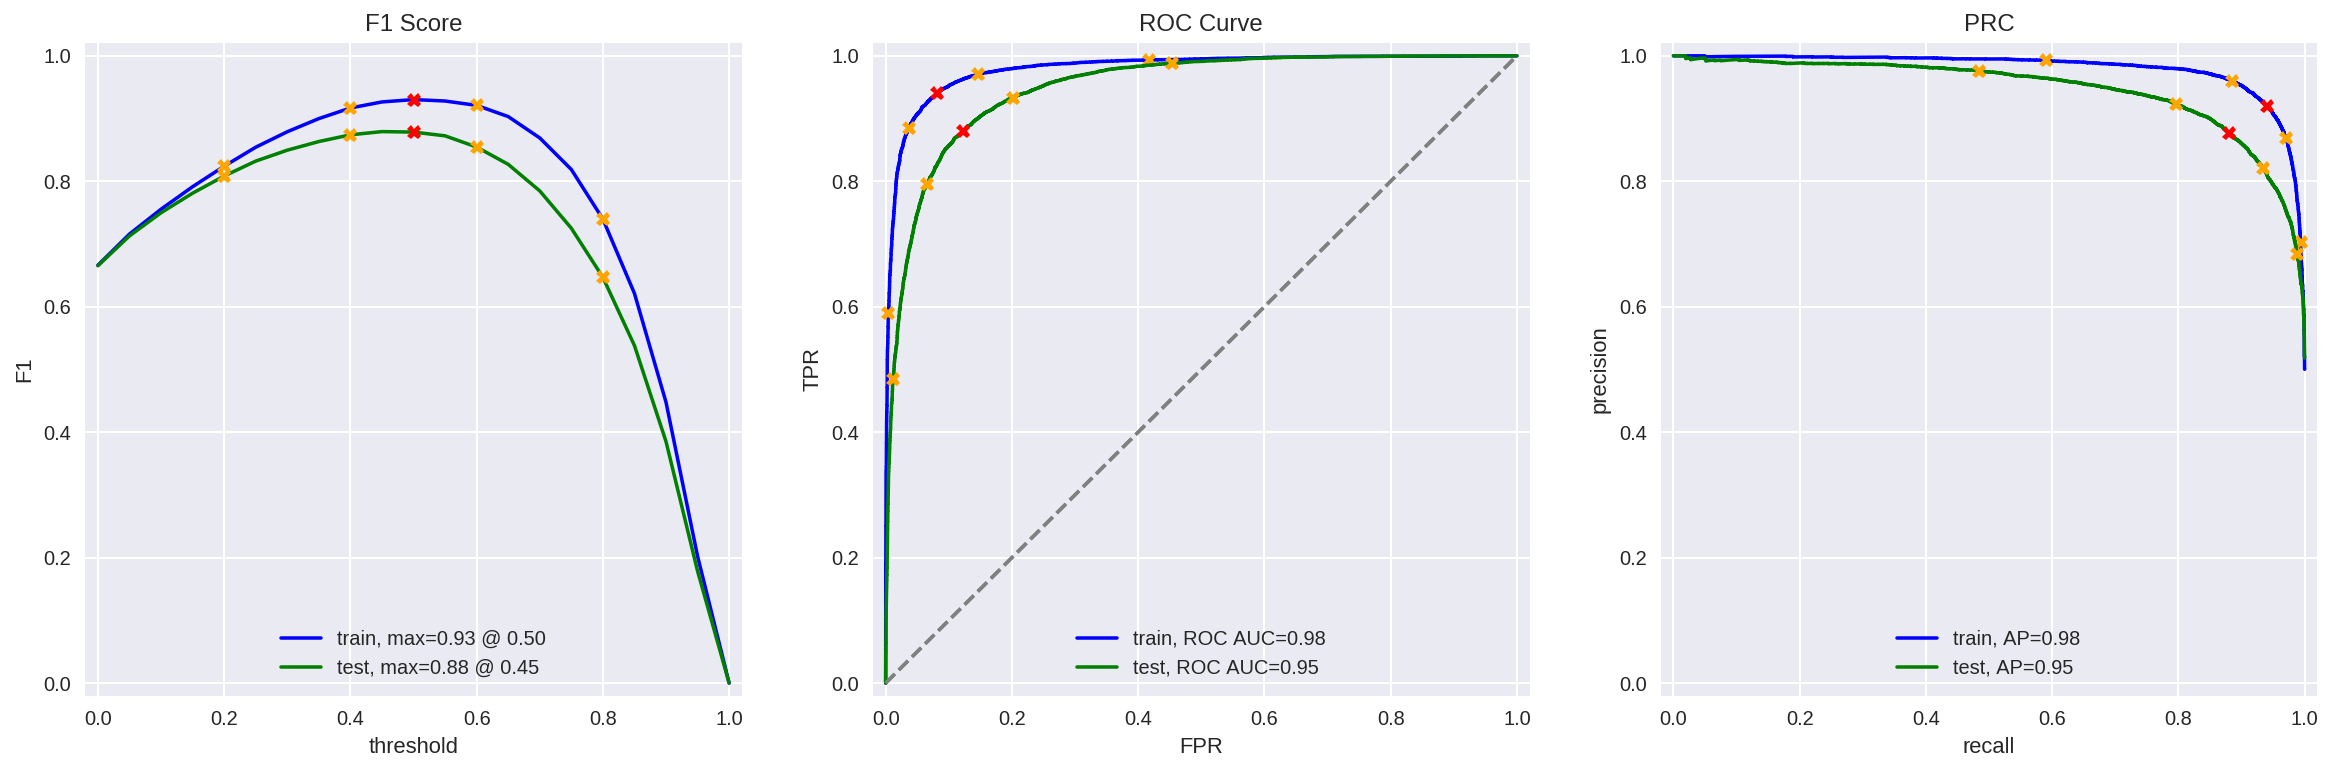

In [45]:
evaluate_model(logistic_clf_2, train_features_2, train_target, test_features_2, test_target)

# Model 4 - spaCy, TF-IDF and LGBMClassifier

In [46]:
from lightgbm import LGBMClassifier

In [47]:
lgbm_clf =LGBMClassifier()

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features_2, train_target, test_size=0.33, random_state=42)

In [49]:
def algorithm_pipeline(X_train_data, X_valid_data, y_train_data, y_valid_data, 
                       model, param_grid, cv=5, scoring_fit='f1',
                       do_probabilities = False, cat_features=None):
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_valid_data)
    else:
        pred = fitted_model.predict(X_valid_data)
    
    return fitted_model, pred

In [50]:
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40, 60]
}

estimator, pred = algorithm_pipeline(X_train, X_valid, y_train, y_valid, lgbm_clf, 
                                 param_grid, cv=5)

best_lgbm_classifier = estimator.best_estimator_
print(estimator.best_score_)
print(estimator.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] learning_rate=0.01, n_estimators=20 .............................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=0.01, n_estimators=20, total=  15.3s
[CV] learning_rate=0.01, n_estimators=20 .............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=20, total=  15.2s
[CV] learning_rate=0.01, n_estimators=20 .............................
[CV] .............. learning_rate=0.01, n_estimators=20, total=  15.3s
[CV] learning_rate=0.01, n_estimators=20 .............................
[CV] .............. learning_rate=0.01, n_estimators=20, total=  17.3s
[CV] learning_rate=0.01, n_estimators=20 .............................
[CV] .............. learning_rate=0.01, n_estimators=20, total=  15.2s
[CV] learning_rate=0.01, n_estimators=40 .............................
[CV] .............. learning_rate=0.01, n_estimators=40, total=  28.0s
[CV] learning_rate=0.01, n_estimators=40 .............................
[CV] .............. learning_rate=0.01, n_estimators=40, total=  29.2s
[CV] learning_rate=0.01, n_estimators=40 .............................
[CV] .............. learning_rate=0.01, n_estimators=40, total=  28.6s
[CV] learning_rate=0.01, n_estimators=40 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 22.9min finished


0.8392646078610444
{'learning_rate': 1, 'n_estimators': 60}


          train  test
Accuracy   0.94  0.83
F1         0.94  0.83
APS        0.98  0.91
ROC AUC    0.98  0.91


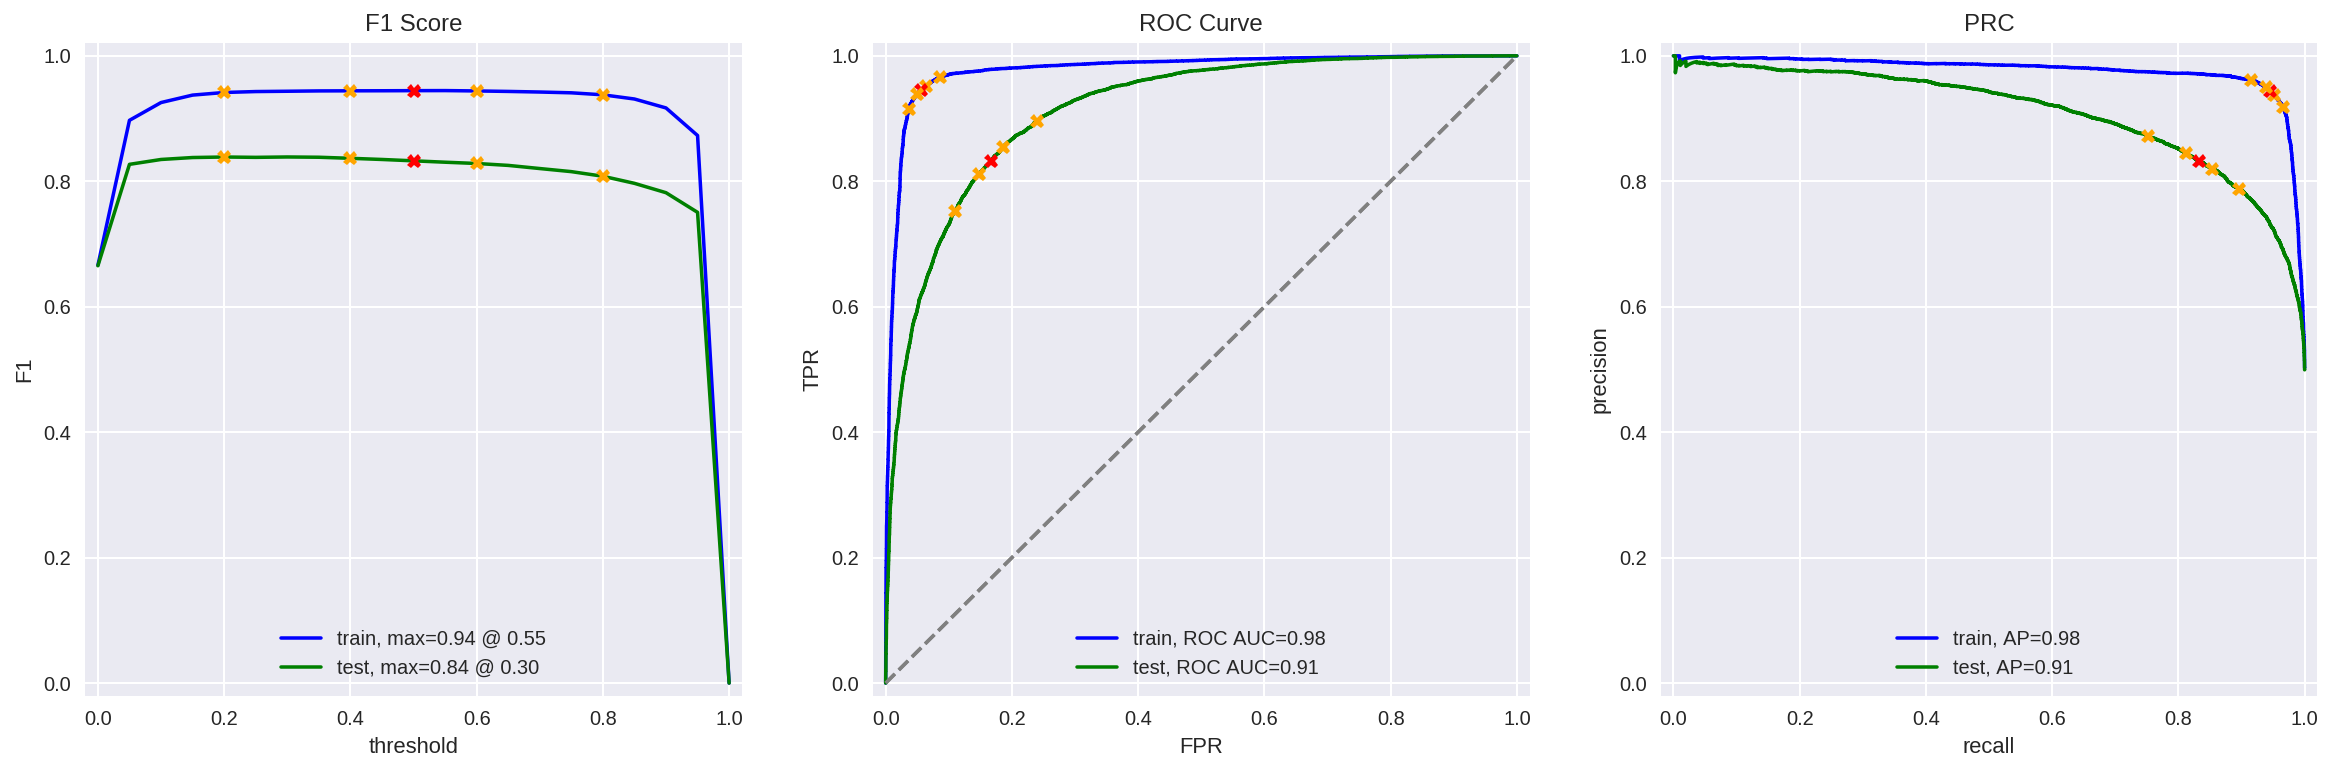

In [51]:
evaluate_model(best_lgbm_classifier, train_features_2, train_target, test_features_2, test_target)

In [54]:
lgbm_clf =LGBMClassifier(learning_rate= 1, n_estimators=60)
lgbm_clf.fit(train_features_2, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=60, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy    1.0  0.84
F1          1.0  0.84
APS         1.0  0.91
ROC AUC     1.0  0.92


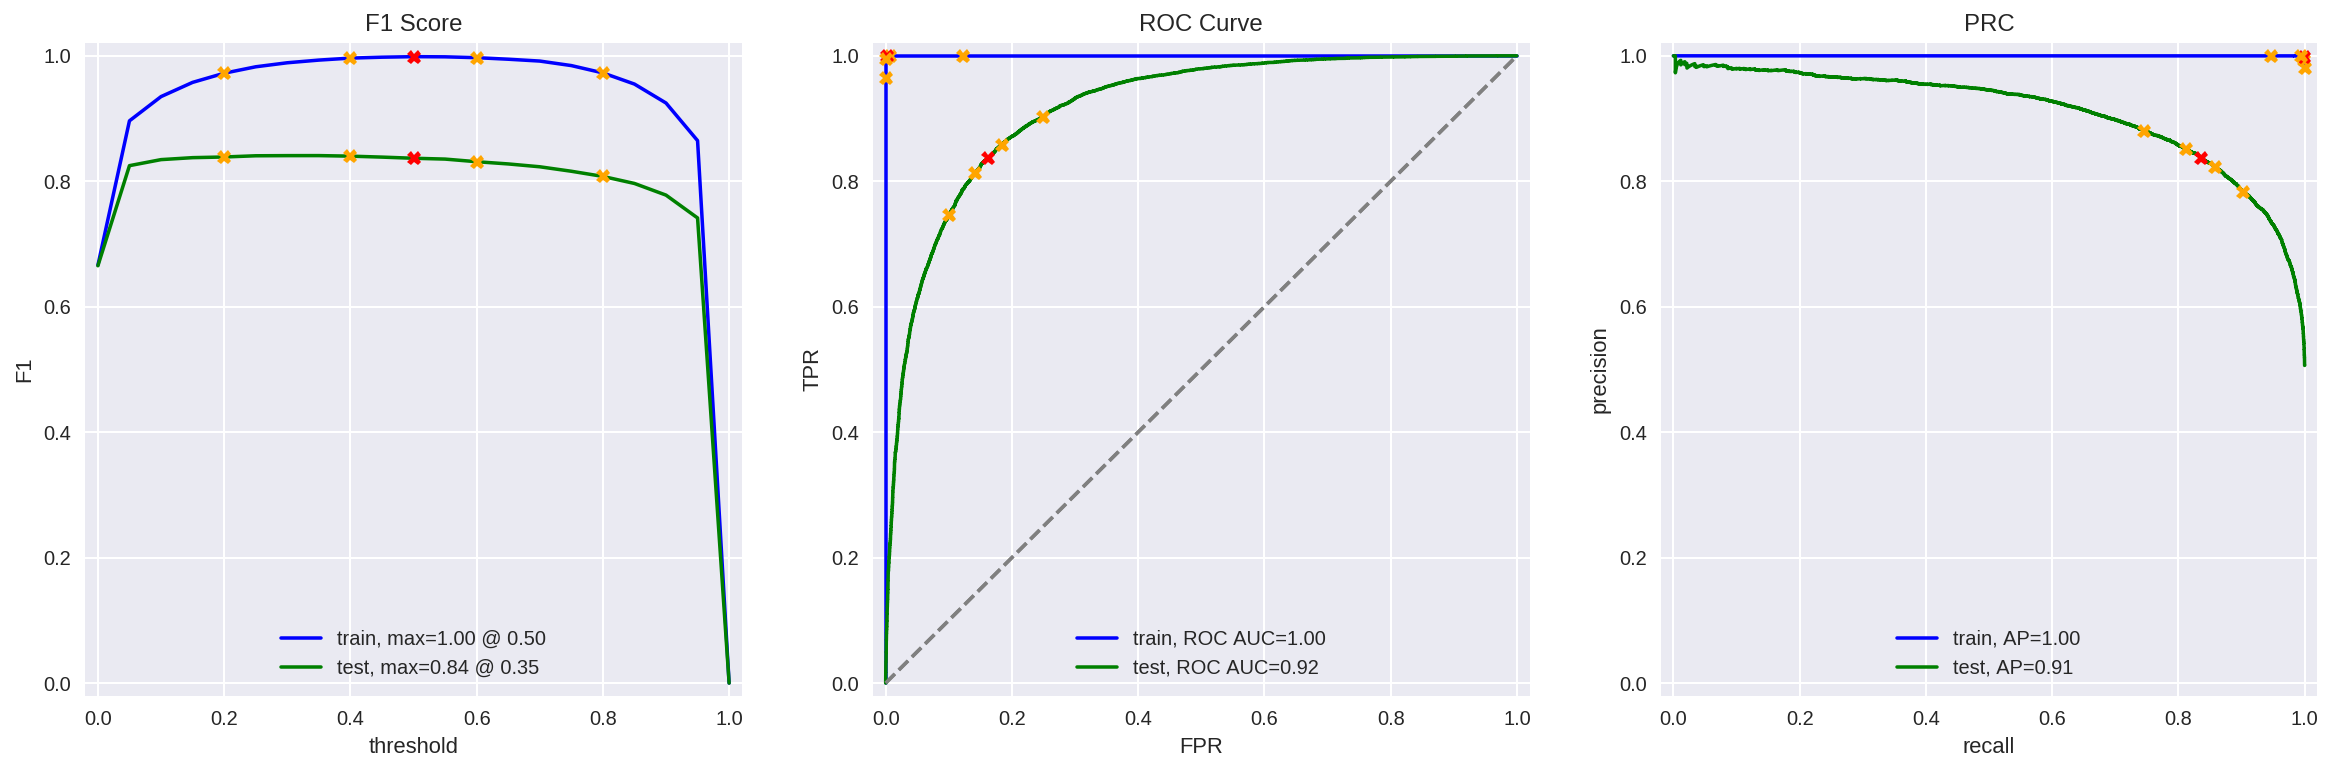

In [55]:
evaluate_model(lgbm_clf, train_features_2, train_target, test_features_2, test_target)

In [60]:
lgbm_clf_2 =LGBMClassifier()
lgbm_clf_2.fit(train_features_2, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


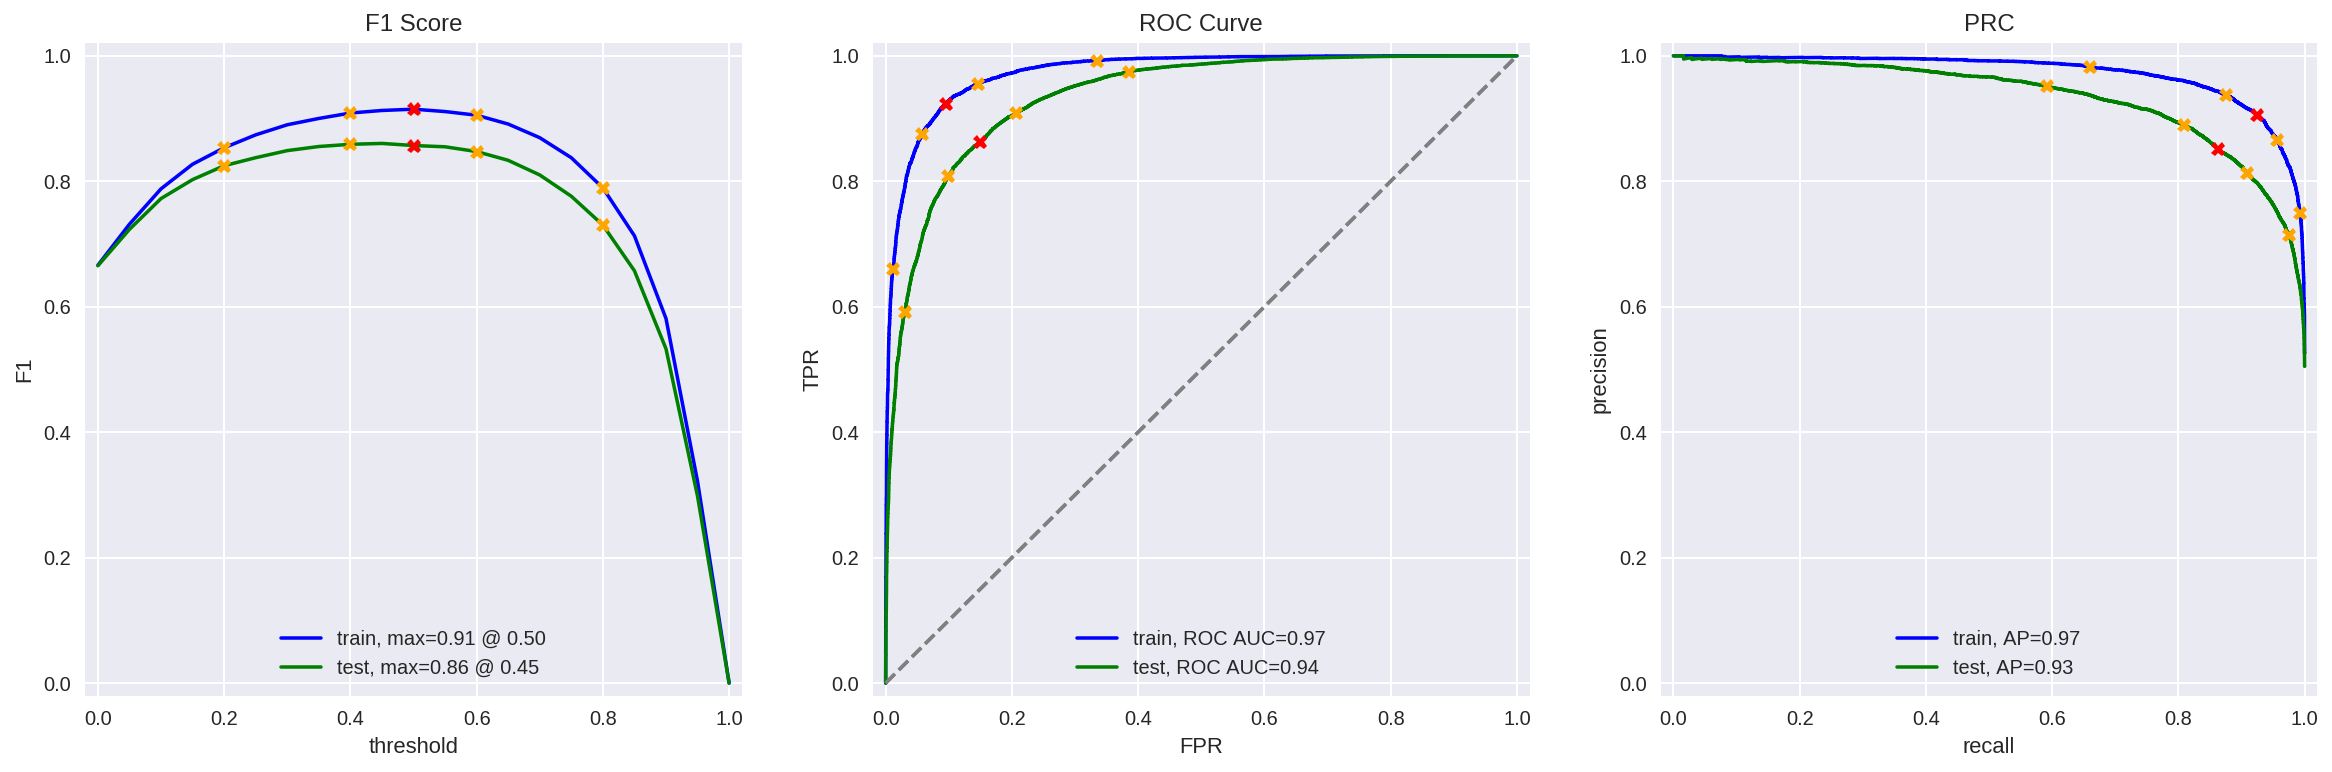

In [61]:
evaluate_model(lgbm_clf_2, train_features_2, train_target, test_features_2, test_target)

With default parameter we are getting better result compare to Best Default choosen Hyper Parameter

#  Model 9 - BERT

In [62]:
import torch
import transformers

In [63]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [64]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [92]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_2 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [93]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)


NameError: name 'train_features_9' is not defined

In [94]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

(23535,)


NameError: name 'test_features_9' is not defined

In [95]:
logistic_clf_3 = LogisticRegression()
logistic_clf_3.fit(train_features_9, train_target)

NameError: name 'train_features_9' is not defined

In [97]:
evaluate_model(logistic_clf_3, train_features_9, train_target, test_features_9, test_target)

NameError: name 'train_features_9' is not defined

In [70]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

# My Reviews

In [71]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)
my_reviews['review_norm']

0        i did not simply like it not my kind of movie
1    well i was bored and felt asleep in the middle...
2               i was really fascinated with the movie
3    even the actors looked really old and disinter...
4    i didn't expect the reboot to be so good write...
5    the movie had its upsides and downsides but i ...
6    what a rotten attempt at a comedy not a single...
7    launching on netflix was a brave move i really...
Name: review_norm, dtype: object


## Model 1

In [72]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = logistic_clf_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Model 2 

In [74]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = logistic_clf_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.27:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.41:  i didn't expect the reboot to be so good writers really cared about the source material
0.37:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.11:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Model 3 

In [77]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm_clf.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.79:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.13:  i didn't expect the reboot to be so good writers really cared about the source material
0.81:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Model 4 

In [80]:
#texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tfidf_vectorizer_2
#my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Model 9 : BERT

In [84]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = logistic_clf_3.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

ValueError: need at least one array to concatenate

# Results:

<table><tr><th>Model</th><th>Embedding Method</th><th>F1 Score for Test Data</th><th>F1 Score for Train Data</th></tr>
    <tr><td>Logistic Regression</td><td>NLTK, TF-IDF</td><td>0.88</td><td>0.94</td></tr>
    <tr><td>Logistic Regression</td><td>Spacy, TF-IDF</td><td>0.88</td><td>0.93</td></tr>
    <tr><td>LightLGBM</td><td>Spacy, TF-IDF</td><td>0.86</td><td>0.91</td></tr>
    <tr><td>Logistic Regression</td><td>BERT</td><td>0.86</td><td>0.88</td></tr></table>

## CONCLUSIONS:

**For Logistic Regression Model if we check different embedding methods in the results, NLTK and Spacy with TFIDF is giving better results compare to Bert Embedding**

**Model is overfitting in case of NLTK and SPacy with TFIDF while if we use Bert Embedding it doesn't overfit. It shows that if we train more complex model with hyper parameter tuning it might give better results.**

**On My Review Section the model with bert Embedding is able to differentiate positive and negative with more probability score.**

**We wanted to compare diffrent word embedding methods here so i used simple model like Logistic Regression. It was giving required F1 Score so i didn't try Hyperparameter tuning. If i want to have more accuracy than i will use LightGBM/Catboost with proper hyperparameter tuning.**

# Check List

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions